In [143]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from IPython.display import display

PSI2PA = 6894.76


OF = 1

# Propellant Temperatures [K]
T_amb = 298
T_ox = 298
T_fuel = 298
T_mix = T_ox *(OF/(OF+1)) + T_fuel *(OF/(OF+1))

# Propellant Pressures [Pa]
P_wsr = 500 * PSI2PA
P_amb = ct.one_atm

# Mass Flow Rates [kg/s]
mdot_total = 0.12
mdot_ox = mdot_total*(OF/(OF+1))
mdot_fuel = mdot_total*(1/(OF+1))


## Define Reactor Network ##

# Jet-A reaction mechanism
mech = "A2NTC_skeletal.yaml"

# Gas Compositions #

# Pre-Mixed Inlet
Y_mix = {"POSF10325": (1/(OF+1)), "O2": (OF/(OF+1))}
sol_inlet = ct.Solution(mech)
sol_inlet.TPY = T_mix, P_wsr, Y_mix

# Arbitrary Exhaust 
sol_exhaust = ct.Solution(mech)
#sol_exhaust.TP = T_amb, P_amb

# Reservoirs
res_inlet = ct.Reservoir(sol_inlet, clone=True)
res_exhaust = ct.Reservoir(sol_exhaust, clone=True)

# Well Stirred Reactor
rctr_wsr = ct.ConstPressureReactor(sol_inlet, energy='on')

# Mass Flow Controllers
mfc_inlet = ct.MassFlowController(upstream=res_inlet, downstream=rctr_wsr, mdot=mdot_total)
mfc_outlet = ct.MassFlowController(upstream=rctr_wsr, downstream=res_exhaust, mdot=mdot_total)
#pc_outlet = ct.PressureController(upstream=rctr_wsr, downstream=res_exhaust, primary=mfc_inlet, K=1e-3)

sim = ct.ReactorNet([rctr_wsr])

C:\Users\Louis\AppData\Local\Temp\ipykernel_35568\1435041509.py:50: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  rctr_wsr = ct.ConstPressureReactor(sol_inlet, energy='on')


In [144]:
# Create a SolutionArray to store the data
time_history = ct.SolutionArray(rctr_wsr.thermo, extra=["t"])
max_sim_time = 500
# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < max_sim_time:
    t = sim.step()

    # We will store only every 10th value. Remember, we have 1200+ species, so there
    # will be 1200+ columns for us to work with
    if counter % 10 == 0:
        # Extract the state of the reactor
        time_history.append(rctr_wsr.thermo.state, t=t)

    counter += 1

# Stop the stopwatch
toc = time.time()
print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")

Simulation Took 0.00s to compute, with 7 steps


C:\Users\Louis\AppData\Local\Temp\ipykernel_35568\4139110179.py:2: DeprecationWarning: ReactorBase.thermo: To be removed after Cantera 3.2. Renamed to `phase`.
  time_history = ct.SolutionArray(rctr_wsr.thermo, extra=["t"])


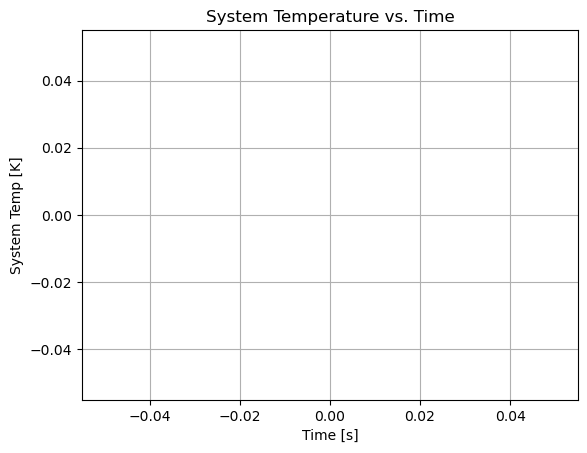

In [145]:
plt.figure()
plt.plot(time_history.t, time_history.T, '-o')
plt.xlabel('Time [s]')
plt.ylabel('System Temp [K]')
plt.title("System Temperature vs. Time")
plt.grid(True)
plt.show()

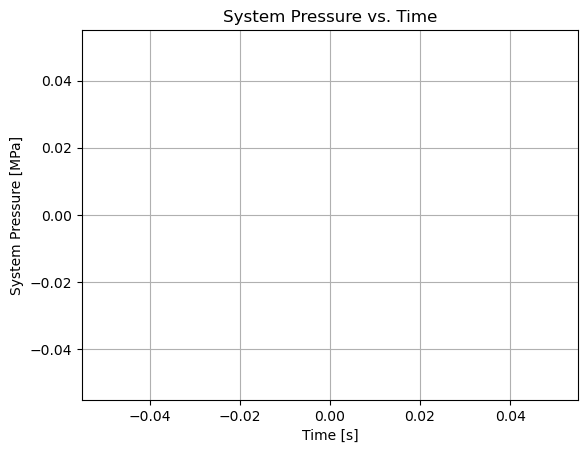

In [146]:
plt.figure()
plt.plot(time_history.t, time_history.P * 1e-6, '-o')
plt.xlabel('Time [s]')
plt.ylabel('System Pressure [MPa]')
plt.title("System Pressure vs. Time")
plt.grid(True)
plt.show()

In [147]:
rctr_wsr

In [148]:
time_history.P

array([], dtype=float64)

In [149]:
df = time_history.to_pandas()
sim.solve_steady()

In [150]:
gas = rctr_wsr.phase
print(gas.T, gas.P / PSI2PA, gas.h)

298.0000000000036 499.99999999999994 -906872.9965402201


C:\Users\Louis\AppData\Local\Temp\ipykernel_79784\836435301.py:50: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  rctr_wsr = ct.ConstPressureReactor(inlet, energy='on')


Simulation Took 0.28s to compute, with 4114 steps


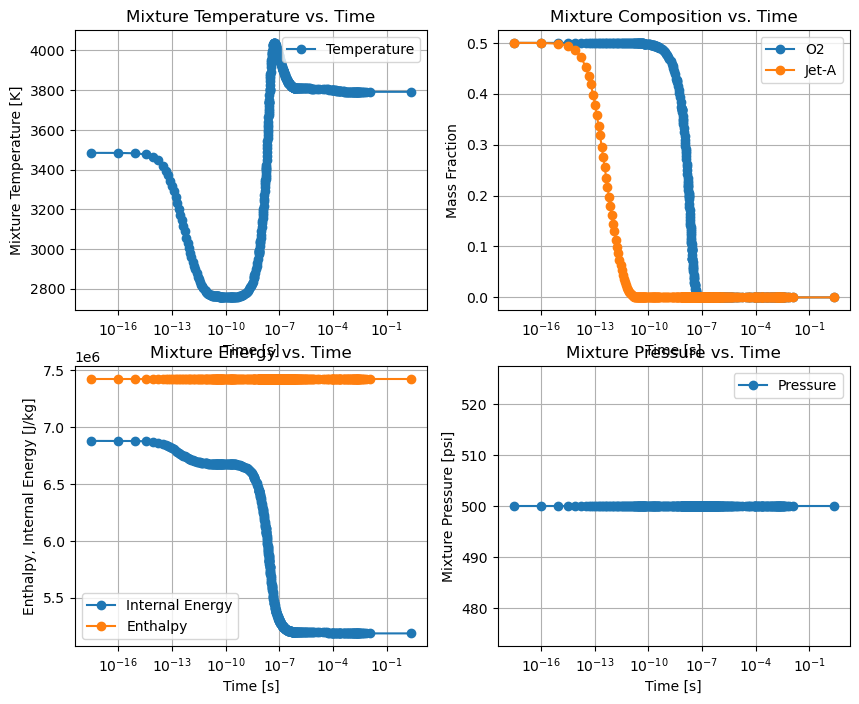

           T        D    POSF10325         C2H4  ...   A2C11H21O4   A2C11H20O3   N2            t
0    3483.91  6.30804  4.99995e-01  1.61135e-06  ...  2.43710e-38  3.06334e-44    0  2.90026e-18
1    3483.68  6.30689  4.99824e-01  5.56311e-05  ...  2.36322e-32  6.91287e-37    0  1.00181e-16
2    3481.84  6.29766  4.98456e-01  4.89012e-04  ...  1.47386e-28  3.64866e-32    0  8.84174e-16
3    3476.09  6.26912  4.94183e-01  1.84277e-03  ...  3.61833e-26  3.27419e-29    0  3.37439e-15
4    3465.12  6.21591  4.86049e-01  4.41873e-03  ...  1.66687e-24  3.60207e-27    0  8.29144e-15
..       ...      ...          ...          ...  ...          ...          ...  ...          ...
406  3791.22  1.53798  6.27807e-16  3.11771e-05  ...  4.38563e-46  1.61275e-45    0  4.57683e-03
407  3791.22  1.53798  6.27807e-16  3.11771e-05  ...  4.38563e-46  1.61275e-45    0  5.58661e-03
408  3791.22  1.53798  6.27807e-16  3.11771e-05  ...  4.38563e-46  1.61275e-45    0  7.27189e-03
409  3791.22  1.53798  6.27807

In [30]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

PSI2PA = 6894.76

## Experiment Set Up ##
OF = 1
residence_time = 100 # [s]

# Propellant Temperatures [K]
T_comb = 2500
T_amb = 298
T_ox = 298
T_fuel = 298
T_mix = T_ox *(OF/(OF+1)) + T_fuel *(1/(OF+1))

# Propellant Pressures [Pa]
P_wsr = 500 * PSI2PA
P_amb = 14.7 * PSI2PA

# Mass Flow Rates [kg/s]
mdot_total = 0.12
mdot_ox = mdot_total*(OF/(OF+1))
mdot_fuel = mdot_total*(1/(OF+1))

# Jet-A reaction mechanism
mech = "A2NTC_skeletal.yaml"

# Gas Compositions #
# Pre-Mixed Inlet
Y_mix = {"POSF10325": (1/(OF+1)), "O2": (OF/(OF+1))}
sol_inlet = ct.Solution(mech)
sol_inlet.TPY = T_mix, P_wsr, Y_mix

# Arbitrary Exhaust 
sol_exhaust = ct.Solution(mech)
sol_exhaust.TP = T_amb, P_amb

def define_network(inlet):
## Define Reactor Network ##

    # Reservoirs
    res_inlet = ct.Reservoir(inlet, clone=True)
    res_exhaust = ct.Reservoir(sol_exhaust, clone=True)

    # Well Stirred Reactor & set residence time to be internally conistent with volume
    rctr_wsr = ct.ConstPressureReactor(inlet, energy='on')
    rho_inlet = rctr_wsr.density 
    rctr_wsr.volume = mdot_total * residence_time / rho_inlet
    
    # Mass Flow Controllers
    mfc_inlet = ct.MassFlowController(upstream=res_inlet, downstream=rctr_wsr, mdot=mdot_total)
    mfc_outlet = ct.MassFlowController(upstream=rctr_wsr, downstream=res_exhaust, mdot=mdot_total)
    #pc_outlet = ct.PressureController(upstream=rctr_wsr, downstream=res_exhaust, primary=mfc_inlet, K=1e-5)

    sim = ct.ReactorNet([rctr_wsr])
    
    return sim, rctr_wsr

def add_energy(E_ign):
    # Returns Clone with Added Enthalpy to Inlet Mixture, keep other properties the same
    inlet_clone = ct.Solution(mech)
    inlet_clone.TPY = T_mix, P_wsr, Y_mix
    dh = E_ign / mdot_total
    inlet_clone.HPY = inlet_clone.h + dh , inlet_clone.P, inlet_clone.Y

    return inlet_clone

def ignites(E_ign, plotFlag=False):
    inlet_clone = add_energy(1e6)
    (sim, rctr_wsr) = define_network(inlet_clone)
    sim.step()
    rctr_wsr.phase.HPY = sol_inlet.h + 1e5/mdot_total, sol_inlet.P, sol_inlet.Y
    if plotFlag:
        time_history = ct.SolutionArray(sol_inlet, extra=["t"])
        max_sim_time = 500 #[s]
        step_solution(time_history, max_sim_time, rctr_wsr, sim)
        print(time_history)
        return True

    else:
        t = 0.0
        while t < residence_time:
            t = sim.step()

            if rctr_wsr.phase.T > T_comb:
                return True

def step_solution(time_history, max_sim_time, reactor, sim):
    # Start the stopwatch
    tic = time.time()

    # Set simulation start time to zero
    t = 0
    counter = 1
    while t < max_sim_time:
        t = sim.step()

        # We will store only every 10th value. Remember, we have 1200+ species, so there
        # will be 1200+ columns for us to work with
        if counter % 10 == 0:
            # Extract the state of the reactor
            time_history.append(reactor.phase.state, t=t)

        counter += 1

    # Stop the stopwatch
    toc = time.time()
    print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")
    
    #plot results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    axes[0,0].semilogx(time_history.t, time_history.T,"-o", label="Temperature")
    axes[0,0].set_xlabel("Time [s]")
    axes[0,0].set_ylabel("Mixture Temperature [K]")
    axes[0,0].set_title("Mixture Temperature vs. Time")
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    axes[1,1].semilogx(time_history.t, time_history.P / PSI2PA,"-o", label="Pressure")
    axes[1,1].set_xlabel("Time [s]")
    axes[1,1].set_ylabel("Mixture Pressure [psi]")
    axes[1,1].set_title("Mixture Pressure vs. Time")
    axes[1,1].legend()
    axes[1,1].grid(True)

    axes[0,1].semilogx(time_history.t, time_history.O2, "-o", label="O2")
    axes[0,1].semilogx(time_history.t, time_history.POSF10325, "-o", label="Jet-A")
    axes[0,1].set_xlabel("Time [s]")
    axes[0,1].set_ylabel("Mass Fraction")
    axes[0,1].set_title("Mixture Composition vs. Time")  
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    axes[1,0].semilogx(time_history.t, time_history.u, "-o", label="Internal Energy")
    axes[1,0].semilogx(time_history.t, time_history.h, "-o", label='Enthalpy')
    axes[1,0].set_xlabel("Time [s]")
    axes[1,0].set_ylabel("Enthalpy, Internal Energy [J/kg]")
    axes[1,0].set_title("Mixture Energy vs. Time")  
    axes[1,0].legend()
    axes[1,0].grid(True)
    plt.show()

    return time_history

def steady_solve(sim, reactor):
    # Solve Sim to Steady State
    tic = time.time()
    sim.solve_steady()
    toc = time.time()
    print(f"Simulation Completed in {toc-tic:3.2f} seconds.")
    print(f"Final State: {reactor.T} K, {reactor.thermo.P / PSI2PA} psi")
    
    return reactor.T, reactor.thermo.P

def main():
    # Find Minimum Ignition Energy Case

    """     # MIE upper/lower bound guesses [J]
    E_low = 0.0
    E_high = 1000 

    # Bisecton Search to find MIE #
    if not ignites(E_high):
        raise RuntimeError("Upper bound too low — increase E_high")
    for xx in range(30):
        E_mid = 0.5 * (E_low + E_high)

        if ignites(E_mid):
            E_high = E_mid
        else:
            E_low = E_mid

        E_min = E_high
    print(f"Minimum Ignition Energy: {E_min:0.3f} J")"""

    # Once Minimum Ignition Energy Case is Found
    ## Step Through Solution to Get Temporal Data ## 
    ignites(0, plotFlag=True)
    
    
    return
if __name__ == "__main__":
    main()

In [31]:
## Define Reactor Network ##

# Reservoirs
res_inlet = ct.Reservoir(sol_inlet, clone=True)
res_exhaust = ct.Reservoir(sol_exhaust, clone=True)

# Well Stirred Reactor & set residence time to be internally conistent with volume
rctr_wsr = ct.ConstPressureReactor(sol_inlet, energy='on')
rho_inlet = rctr_wsr.density 
rctr_wsr.volume = mdot_total * residence_time / rho_inlet

# Mass Flow Controllers
mfc_inlet = ct.MassFlowController(upstream=res_inlet, downstream=rctr_wsr, mdot=mdot_total)
mfc_outlet = ct.MassFlowController(upstream=rctr_wsr, downstream=res_exhaust, mdot=mdot_total)
#pc_outlet = ct.PressureController(upstream=rctr_wsr, downstream=res_exhaust, primary=mfc_inlet, K=1e-5)

sim = ct.ReactorNet([rctr_wsr])


C:\Users\Louis\AppData\Local\Temp\ipykernel_79784\1609882243.py:8: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  rctr_wsr = ct.ConstPressureReactor(sol_inlet, energy='on')
